Key types of features include:
- Passenger demographics (Age, HomePlanet)
- Travel configuration (Cabin, Destination)
- Behavioral signals (CryoSleep, luxury spending)
- Target label: **Transported** (True / False)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")


In [2]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

print(train.shape, test.shape)
train.head()

(8693, 14) (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
train.describe()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


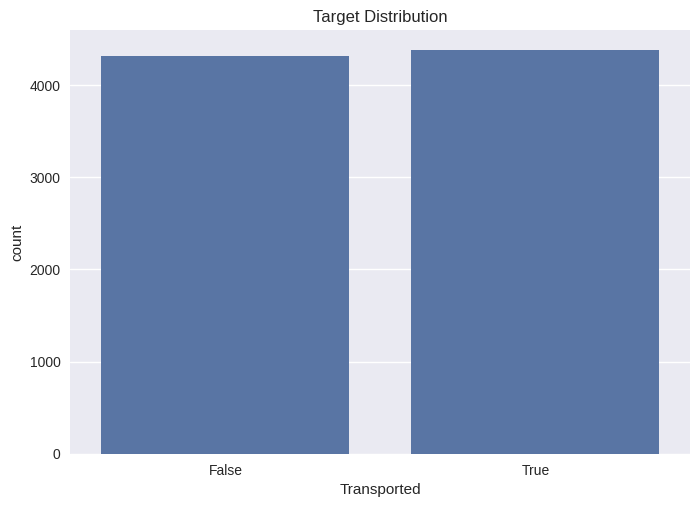

In [5]:
sns.countplot(x="Transported", data=train)
plt.title("Target Distribution")
plt.show()


In [6]:
missing = train.isnull().mean().sort_values(ascending=False)
missing[missing > 0]


CryoSleep       0.024963
ShoppingMall    0.023927
VIP             0.023352
HomePlanet      0.023122
Name            0.023007
Cabin           0.022892
VRDeck          0.021627
Spa             0.021051
FoodCourt       0.021051
Destination     0.020936
RoomService     0.020821
Age             0.020591
dtype: float64

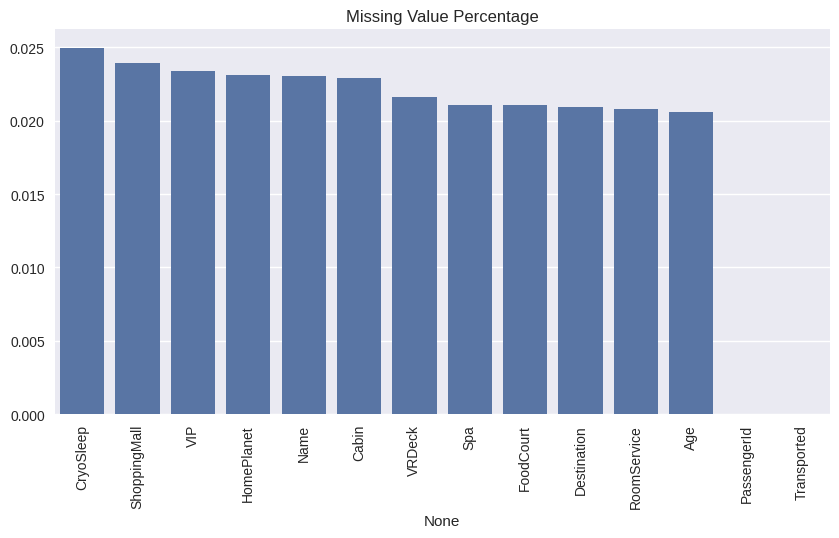

In [7]:
plt.figure(figsize=(10,5))
sns.barplot(x=missing.index, y=missing.values)
plt.xticks(rotation=90)
plt.title("Missing Value Percentage")
plt.show()


Before modeling, we explore relationships between features and the target variable.

We focus on:
- CryoSleep vs spending behavior
- Passenger age distribution
- Destination-based transport patterns

In [8]:
for df in [train, test]:
    df[['Group','GroupId']] = df['PassengerId'].str.split('_', expand=True)


In [9]:
for df in [train, test]:
    df[['Deck','CabinNum','Side']] = df['Cabin'].str.split('/', expand=True)


In [10]:
spend_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

for df in [train, test]:
    df['TotalSpend'] = df[spend_cols].sum(axis=1)


In [11]:
for df in [train, test]:
    df['Spend_x_VR'] = df['TotalSpend'] * df['VRDeck']


In [12]:
for df in [train, test]:
    df.loc[df['CryoSleep'] == True, spend_cols] = 0


In [13]:
spend_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

for df in [train, test]:
    has_spending = df[spend_cols].gt(0).any(axis=1)
    df.loc[df['CryoSleep'].isna(), 'CryoSleep'] = ~has_spending


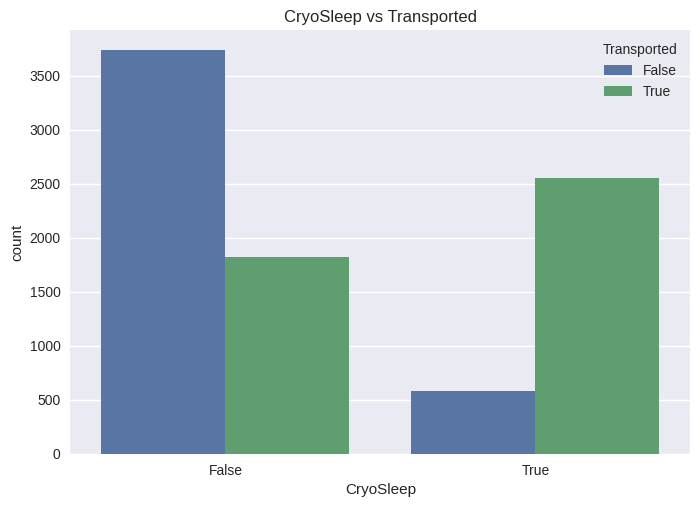

In [14]:
sns.countplot(x="CryoSleep", hue="Transported", data=train)
plt.title("CryoSleep vs Transported")
plt.show()


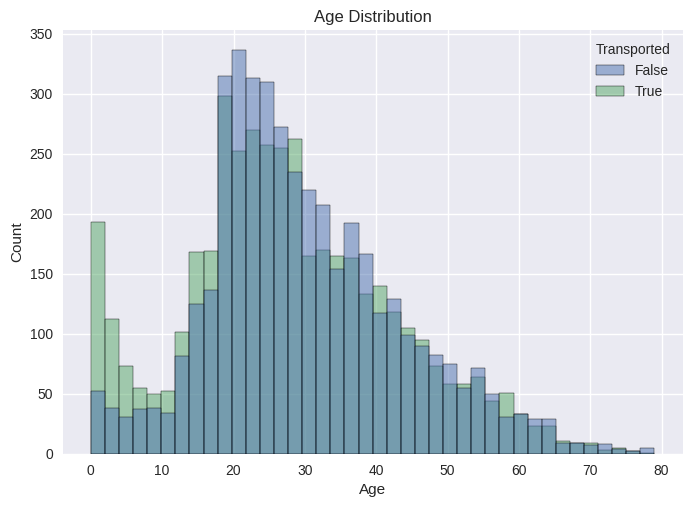

In [15]:
sns.histplot(data=train, x="Age", hue="Transported", bins=40)
plt.title("Age Distribution")
plt.show()


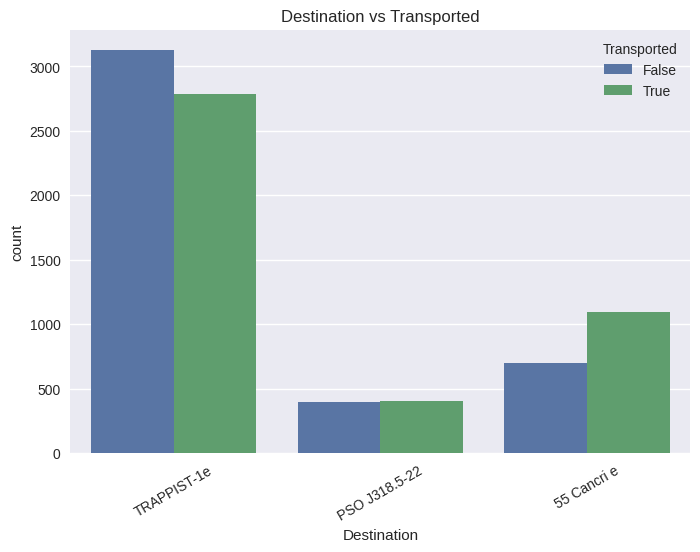

In [16]:
sns.countplot(x="Destination", hue="Transported", data=train)
plt.xticks(rotation=30)
plt.title("Destination vs Transported")
plt.show()


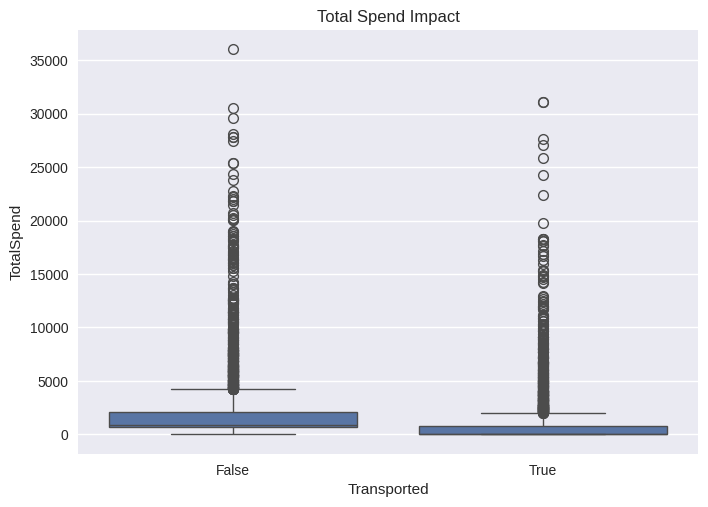

In [17]:
sns.boxplot(x="Transported", y="TotalSpend", data=train)
plt.title("Total Spend Impact")
plt.show()



In [18]:
# Create CabinSize before dropping Cabin
train['CabinSize'] = train.groupby('Cabin')['Cabin'].transform('size')
test['CabinSize'] = test.groupby('Cabin')['Cabin'].transform('size')

# Alone in cabin flag
train['AloneInCabin'] = (train['CabinSize'] == 1).astype(int)
test['AloneInCabin'] = (test['CabinSize'] == 1).astype(int)


In [19]:
drop_cols = ['Name','Cabin','PassengerId']
train = train.drop(columns=drop_cols)
test_ids = test['PassengerId']
test = test.drop(columns=drop_cols)


In [20]:
X = train.drop("Transported", axis=1)
y = train["Transported"]



We enhance the dataset by:
- Extracting information from structured strings (Cabin, PassengerId)
- Aggregating spending behavior
- Encoding categorical variables
- Handling missing values consistently


In [21]:
from sklearn.impute import SimpleImputer


In [22]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns


In [23]:
num_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ]
)


In [24]:
cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)


In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols)
    ]
)


# USING LOGISTIC REGRESSION PIPELINE

![](http://media.geeksforgeeks.org/wp-content/uploads/20240604111859/gh.png)

In [26]:
log_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(
            max_iter=3000,
            solver="lbfgs",
            C=1.5,          # weaker regularization
            n_jobs=-1
        ))
    ]
)


In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

log_model.fit(X_train, y_train)
preds = log_model.predict(X_val)

accuracy_score(y_val, preds)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7734330074755607

# USING RANDOM FOREST AND RANDOM FOREST ENSEMBLE PIPELINES

![](http://machinelearningmastery.com/wp-content/uploads/2020/07/Example-of-Combining-Decision-Boundaries-Using-an-Ensemble.png)


In [28]:
rf_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=300,
            max_depth=12,
            random_state=42
        ))
    ]
)

rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_val)

accuracy_score(y_val, preds)


0.7429557216791259

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np


In [30]:
cat_cols = train.select_dtypes(include='object').columns.tolist()
print(cat_cols)


['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Group', 'GroupId', 'Deck', 'CabinNum', 'Side']


In [31]:
train_encoded = pd.get_dummies(train, columns=cat_cols)
test_encoded = pd.get_dummies(test, columns=cat_cols)


In [32]:
train_encoded, test_encoded = train_encoded.align(
    test_encoded, join='left', axis=1, fill_value=0
)


In [33]:
rf_X = train_encoded.drop(columns=['Transported'])
rf_y = train_encoded['Transported']

rf_X_train, rf_X_val, rf_y_train, rf_y_val = train_test_split(
    rf_X, rf_y, test_size=0.2, stratify=rf_y, random_state=42
)


In [34]:
rf_models = []
seeds = [42, 52, 62]

for seed in seeds:
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        random_state=seed,
        n_jobs=-1
    )
    rf.fit(rf_X_train, rf_y_train)
    rf_models.append(rf)


In [35]:
if 'Transported' in test_encoded.columns:
    test_encoded = test_encoded.drop(columns=['Transported'])


In [36]:
test_encoded = test_encoded[rf_X.columns]


In [37]:
rf_preds = np.mean(
    [rf.predict_proba(test_encoded)[:, 1] for rf in rf_models],
    axis=0
)


The final submission is generated by:
1. Training multiple models
2. Averaging their prediction probabilities
3. Applying a threshold to obtain final labels

![](http://cdn.prod.website-files.com/64a7eed956ba9b9a3c62401d/64e38fcc2a1592dc5f1bab39_lpK-6nLVH-0Z4aJZSgwQYvtmdnqDUuW4D2M8nS7lgypnM0N7PES9YzIg6WipNv6m18_YON3CfCpZzY7OvLDfdRWan8A5ng79tkq1vrQQ5cVgGDeE2trtm7rD6goxs9aOJycNZ7LsqDDXZ-CMOfmooxo.png)

In [38]:
submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': (rf_preds > 0.5)
})

submission.to_csv('submissionRF.csv', index=False)
submission.head()


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,False


In [39]:
test_preds = log_model.predict(test)

submission = pd.DataFrame({
    "PassengerId": test_ids,
    "Transported": test_preds
})

submission.to_csv("submission_logisticReg.csv", index=False)

submission.head()


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [40]:
test_preds = log_model.predict(test)

submission = pd.DataFrame({
    "PassengerId": test_ids,
    "Transported": test_preds
})

submission.to_csv("submission.csv", index=False)

submission.head()


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [41]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", GradientBoostingClassifier(
            n_estimators=400,
            learning_rate=0.04,
            max_depth=3,
            random_state=42
        ))
    ]
)

gb_model.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'TotalSpend', 'Spend_x_VR', 'CabinSize', 'AloneInCabin'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Group', 'GroupId',
       'Deck', 'CabinNum', 'Side'],
      dtype='object'))])),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.04,
                                            n_estimators=400,
                                            random_state=42))])

In [42]:
test_preds = gb_model.predict(test)


In [43]:
submission = pd.DataFrame({
    "PassengerId": test_ids,
    "Transported": test_preds
})

submission.to_csv("submission_gradient_boosting.csv", index=False)
